In [28]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

import queue
from typing import Any, Optional, List
import asyncio
import nest_asyncio
nest_asyncio.apply()

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext
from qubx.impl.ccxt_trading import CCXTSyncTradingConnector
from qubx.impl.ccxt_connector import CCXTDataConnector

from qubx.utils.runner import get_account_config
from qubx.pandaz import scols

from xincubator.models.nimble.aoi_nimblers import NimbleI_AOI


# path to pythonpath /mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments
sys.path.append('/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments')


def clear_queue(q: queue.Queue):
    while not q.empty():
        try:
            q.get_nowait()
        except queue.Empty:
            continue


 >  [dev] installing cython rebuilding hook
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from pathlib import Path
from strats.tradefeed import TradeTestStrat

CONFIG_PATH = Path("/mnt/HC_Volume_100695026/home/shared/devs/Qubx/experiments/configs")

auth = get_account_config(
    "binance-mde", str(CONFIG_PATH / ".env.fishermen2")
)

In [33]:
brok = CCXTSyncTradingConnector('binance', **auth)
data = CCXTDataConnector('binance', brok, **auth)

symbols = ['LINK', 'XRP'] 
instruments = [lookup.find_instrument('BINANCE', s, 'USDT') for s in symbols]

channel = cc.get_communication_channel()
if not channel.control.is_set():
    channel.start()

ctx = StrategyContext(
    TradeTestStrat(), dict(
        capital_invested=100,
        trading_allowed=False
    ), 
    data, brok, instruments=instruments,  # type: ignore
    md_subscription=dict(type='trades', timeframe='1Sec', nback=100),
    # every 10 seconds and on trade
    trigger_spec=[
        "* * * * * */10",
        "trade:"
    ]
)
S = ctx.strategy

try:
    ctx.start(blocking=True)
except KeyboardInterrupt:
    logger.info("Stopped by user")
finally:
    ctx.stop()
    channel.stop()
    clear_queue(channel.queue)

2024-07-08 13:38:09.562 [ ℹ️ ] BINANCE loading ...
2024-07-08 13:38:13.651 [ ℹ️ ] Loading account data for Binance
2024-07-08 13:38:13.894 [ ℹ️ ] BINANCE initialized - current time 2024-07-08T13:38:13.894703000
2024-07-08 13:38:13.896 [ ⚠️ ] qubx.core.loggers:__init__:324 - Log writer is not defined - strategy activity will not be saved !
2024-07-08 13:38:13.896 [ ℹ️ ] (StrategyContext) set strategy parameters:
	set capital_invested <- 100
	set trading_allowed <- False
2024-07-08 13:38:13.898 [ 🐞 ] Triggering strategy on every trade event
2024-07-08 13:38:13.899 [ 🐞 ] Next (time_event) event scheduled at 2024-07-08 13:38:20
2024-07-08 13:38:14.371 [ ℹ️ ] (StrategyContext) Subscribing to trades updates using {'timeframe': '1Sec', 'nback': 100} for 
	['LINKUSDT', 'XRPUSDT'] 
2024-07-08 13:38:14.373 [ ℹ️ ] Subscribed on trades updates for 2 symbols: 
		['LINKUSDT', 'XRPUSDT']
2024-07-08 13:38:14.374 [ ℹ️ ] Listening to trades for LINKUSDT 1s 100...
2024-07-08 13:38:14.375 [ ℹ️ ] > Started

2024-07-08 13:39:03.644 [ 🐞 ] Scheduler is stopped 


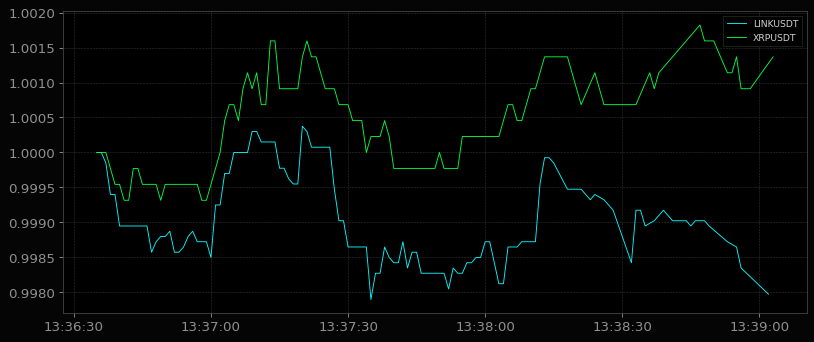

In [34]:
N = lambda x: x / x.iloc[0]
for s, hh in S.ohlcs('1Sec').items():
    plt.plot(N(hh.close), label=s)
plt.legend();